In [1]:
import sys
for i, item in enumerate(sys.path):
    if item.startswith("/share/software/user/"):
        sys.path.pop(i)
        break

In [2]:
import scanpy as sc
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import anndata as ad
from collections import Counter
from scipy.sparse import csr_matrix
import gc
import os, sys
import glob
gc.enable()
from scipy.sparse import csr_matrix

In [3]:
sc.settings.verbosity = 0  
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

-----
anndata     0.10.6
scanpy      1.9.8
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
brotli                      1.0.9
certifi                     2025.08.03
cffi                        1.16.0
charset_normalizer          2.0.4
colorama                    0.4.6
comm                        0.1.4
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.1.3
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
h5py                        3.7.0
idna                        3.4
igraph                      0.11.4
importlib_resources         NA
ipykernel                   6.26.0
ipywid

In [15]:
adata = sc.read_h5ad("./../h5ad/MAIT3.h5ad")
adata.obs["patient_tissue"] = adata.obs["patient_id"].astype(str) + "_" + adata.obs["tissue"].astype(str)
adata

AnnData object with n_obs × n_vars = 36909 × 22223
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'barcode', 'S.Score', 'G2M.Score', 'Phase', 'sample', 'files', 'patient_id', 'tissue', 'batch', 'chip', 'lane', 'sample_number', 'multilane.tn', 'pp3.mana', 'is2.mana', 'jm6.mana', 'center', 'cohort', 'response', 'relapse', 'patno', 'patient', 'imid', 'geid', 'chemo', 'pfs', 'recurrence_n', 'radio_change', 'resi_tumor', 'mpr', 'age', 'sex', 'smoke', 'pack_year', 'hist', 'death', 'date_death', 'clinical_recurrence', 'biopsy_recurrence', 'recurrence', 'date_recurrence', 'path_resec', 'pre_stage', 'pre_stage_com', 'ae', 'grade', 'recist', 'path_down', 'pre_pd.', 'post_pd.', 'mutation', 'number_seq_alteration', 'non_redundant_neoantigens_5000', 'non_redundant_neoantigens_500', 'sample.n', 'integrated_snn_res.0.7', 'seurat_clusters', 'integrated_snn_res.0.3', 'integrated_snn_res.0.6', 'integrated_snn_res.0.5', 'Conventional', 'TRB_nt_1', 'TRB_nt_2', 'TRB_aa_1

In [6]:
temp = adata.obs[["patient_id", "response"]].drop_duplicates()
temp = temp.dropna().reset_index(drop=True)
temp.to_csv("./../patient_response_status.csv")
mapping_dict = dict(zip(temp["patient_id"], temp["response"]))
adata.obs["response"] = adata.obs["patient_id"].map(mapping_dict)
adata.obs["response"].value_counts().sum()

36909

In [7]:
adata.obs["top10_clonotypes"].value_counts()

top10_clonotypes
CASSHRVPNTGELFF-NA_CAAFNNNDMRF-NA                   1949
CSARVGSEVNEQFF-NA_CAATDSNYQLIW-NA                   1415
CSARVGSEVNEQFF-NA_NA                                 708
CASSHRVPNTGELFF-NA_NA                                480
CASSSPSGQYSPLHF-NA_CATRAAGNKLTF-CALSDYGNNRLAF        143
CASSEWGGATDTQYF-NA_CALSTSGGSYIPTF-CALLNQAGTALIF      130
CSARGWQDNEKLFF-NA_CAVRRSNDYKLSF-NA                   130
CSARRRGGGLSDTQYF-NA_CAMRDLNSGNDMRF-CAAGMNRDDKIIF     119
CSAQDLKGEQYF-NA_CIVRVGGGNAGNMLTF-NA                   71
CASNTGTGVGGELFF-NA_CATPASGSARQLTF-NA                  69
Name: count, dtype: int64

In [14]:
adata.obs["beta_chain_temp"] = adata.obs["top10_clonotypes"].astype(str).str.split("_", expand = True)[1]
adata.obs.loc[adata.obs["beta_chain_temp"] == "NA", "top10_clonotypes"] = pd.NA

In [15]:
adata.obs['top10_clonotypes'] = adata.obs['top10_clonotypes'].astype("str")
adata.obs.loc[adata.obs["top10_clonotypes"] == "nan", "top10_clonotypes"] = pd.NA
adata.obs['top10_clonotypes'] = adata.obs['top10_clonotypes'].astype("category")

In [16]:
order1 = list(adata.obs['top10_clonotypes'].cat.categories)
order1[-1], order1[-2] = order1[-2], order1[-1]
adata.obs['top10_clonotypes'] = adata.obs['top10_clonotypes'].cat.reorder_categories(order1)

In [17]:
sorted_index = adata.obs['top10_clonotypes'].sort_values().index
adata = adata[sorted_index, :]

In [18]:
clonotype_colors = ['#17becf',
 '#279e68',
 '#ff7f0e',
 '#8c564b',
 '#b5bd61',
 '#e377c2',
 '#aa40fc',
 '#aec7e8']

In [20]:
# sc.settings.set_figure_params(dpi = 300, dpi_save= 300, fontsize=5, facecolor='white', frameon=True, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
# fig, ax = plt.subplots(figsize = (1.6, 1.6))
# plt.margins(x=0, y=0)
# sc.pl.umap(adata, color = ['top10_clonotypes'], size=3, legend_fontsize=5, 
#            sort_order=True, frameon=False, palette = clonotype_colors,
#            title="All cells", na_in_legend = False, show=False, ax = ax, )
# plt.legend(ncol=1, prop={'size': 5}, handletextpad=0.4, markerscale = 0.6, frameon = False, borderpad=1, columnspacing=0.5,
#            labelspacing = 0.2, loc = 6, bbox_to_anchor = (1.0,0.5), title = "Top clonotypes", alignment = "left",
#            title_fontproperties={'weight':'bold'})
# sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(3.0, 3.0), vector_friendly = False)


In [ ]:
# adata.write_h5ad("./../h5ad/mait_cells_clonotypes_corrected.h5ad")

In [22]:
# adata = sc.read_h5ad("./../h5ad/mait_cells_clonotypes_corrected.h5ad")

/home/groups/quake/mmantri/miniconda3/envs/python3.9/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/groups/quake/mmantri/miniconda3/envs/python3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/groups/quake/mmantri/miniconda3/envs/python3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


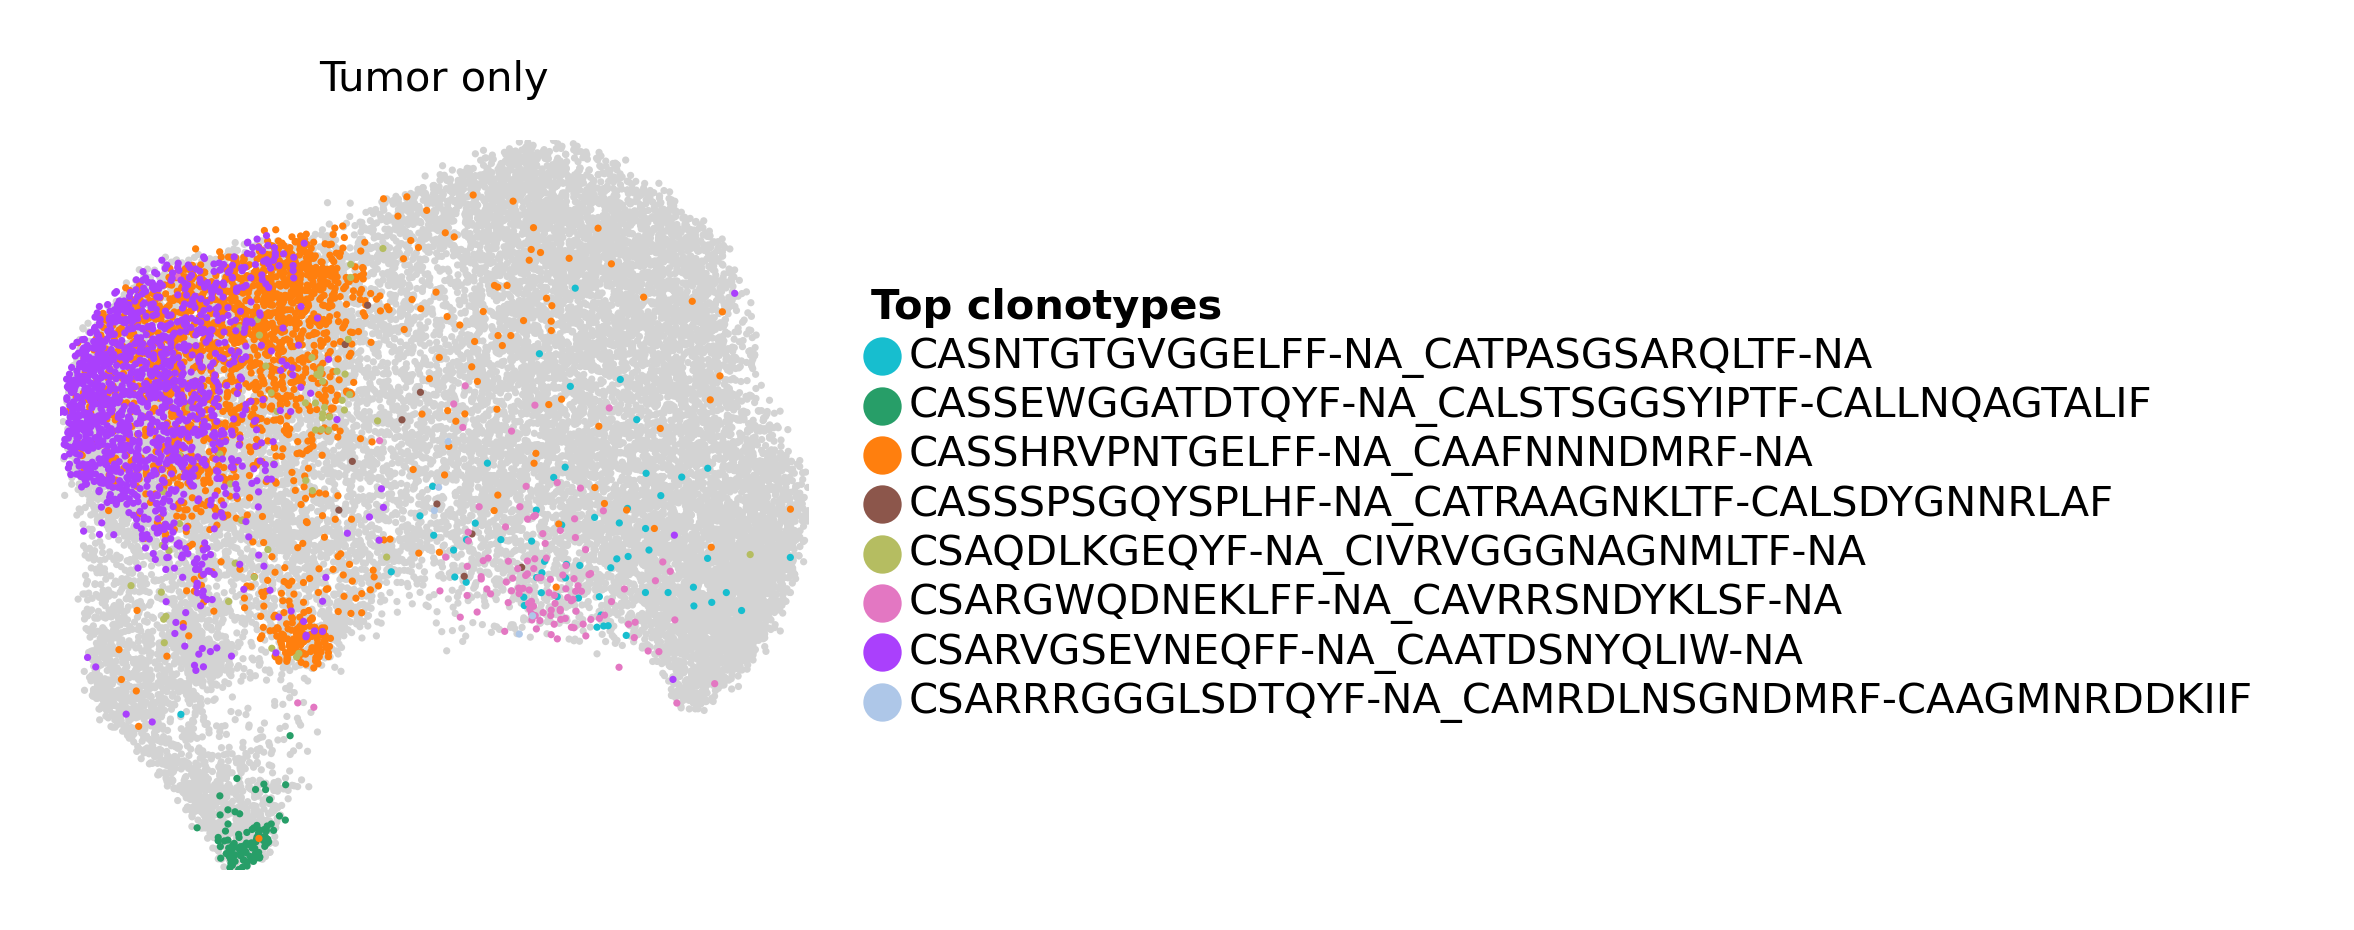

In [23]:
sc.settings.set_figure_params(dpi = 300, dpi_save= 300, fontsize=5, facecolor='white', frameon=True, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize = (1.6, 1.6))
plt.margins(x=0, y=0)
sc.pl.umap(adata[adata.obs["tissue"] == "tumor"], color = ['top10_clonotypes'], size=3, legend_fontsize=5, 
           sort_order=True, frameon=False, palette = clonotype_colors,
           title="Tumor only", na_in_legend = False, show=False, ax = ax, )
plt.legend(ncol=1, prop={'size': 5}, handletextpad=0.4, markerscale = 0.6, frameon = False, borderpad=1, columnspacing=0.5,
           labelspacing = 0.2, loc = 6, bbox_to_anchor = (1.0,0.5), title = "Top clonotypes", alignment = "left",
           title_fontproperties={'weight':'bold'})
# ax.set_ylabel("UMAP2", labelpad = 0.5)
# ax.set_xlabel("UMAP1", labelpad = 0.5)
# plt.savefig("human_figures/SCs_DTC_celltypes.pdf")
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(3.0, 3.0), vector_friendly = False)


In [69]:
patients_of_interest = adata[~pd.isna(adata.obs["top10_clonotypes"])].obs["patient_id"].value_counts().index.values
patients_of_interest

['JS10', 'PP3', 'NY016-015', 'PP4']
Categories (4, object): ['JS10', 'NY016-015', 'PP3', 'PP4']

In [23]:
# Figure 1D 

/home/groups/quake/mmantri/miniconda3/envs/python3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/groups/quake/mmantri/miniconda3/envs/python3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/groups/quake/mmantri/miniconda3/envs/python3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing 

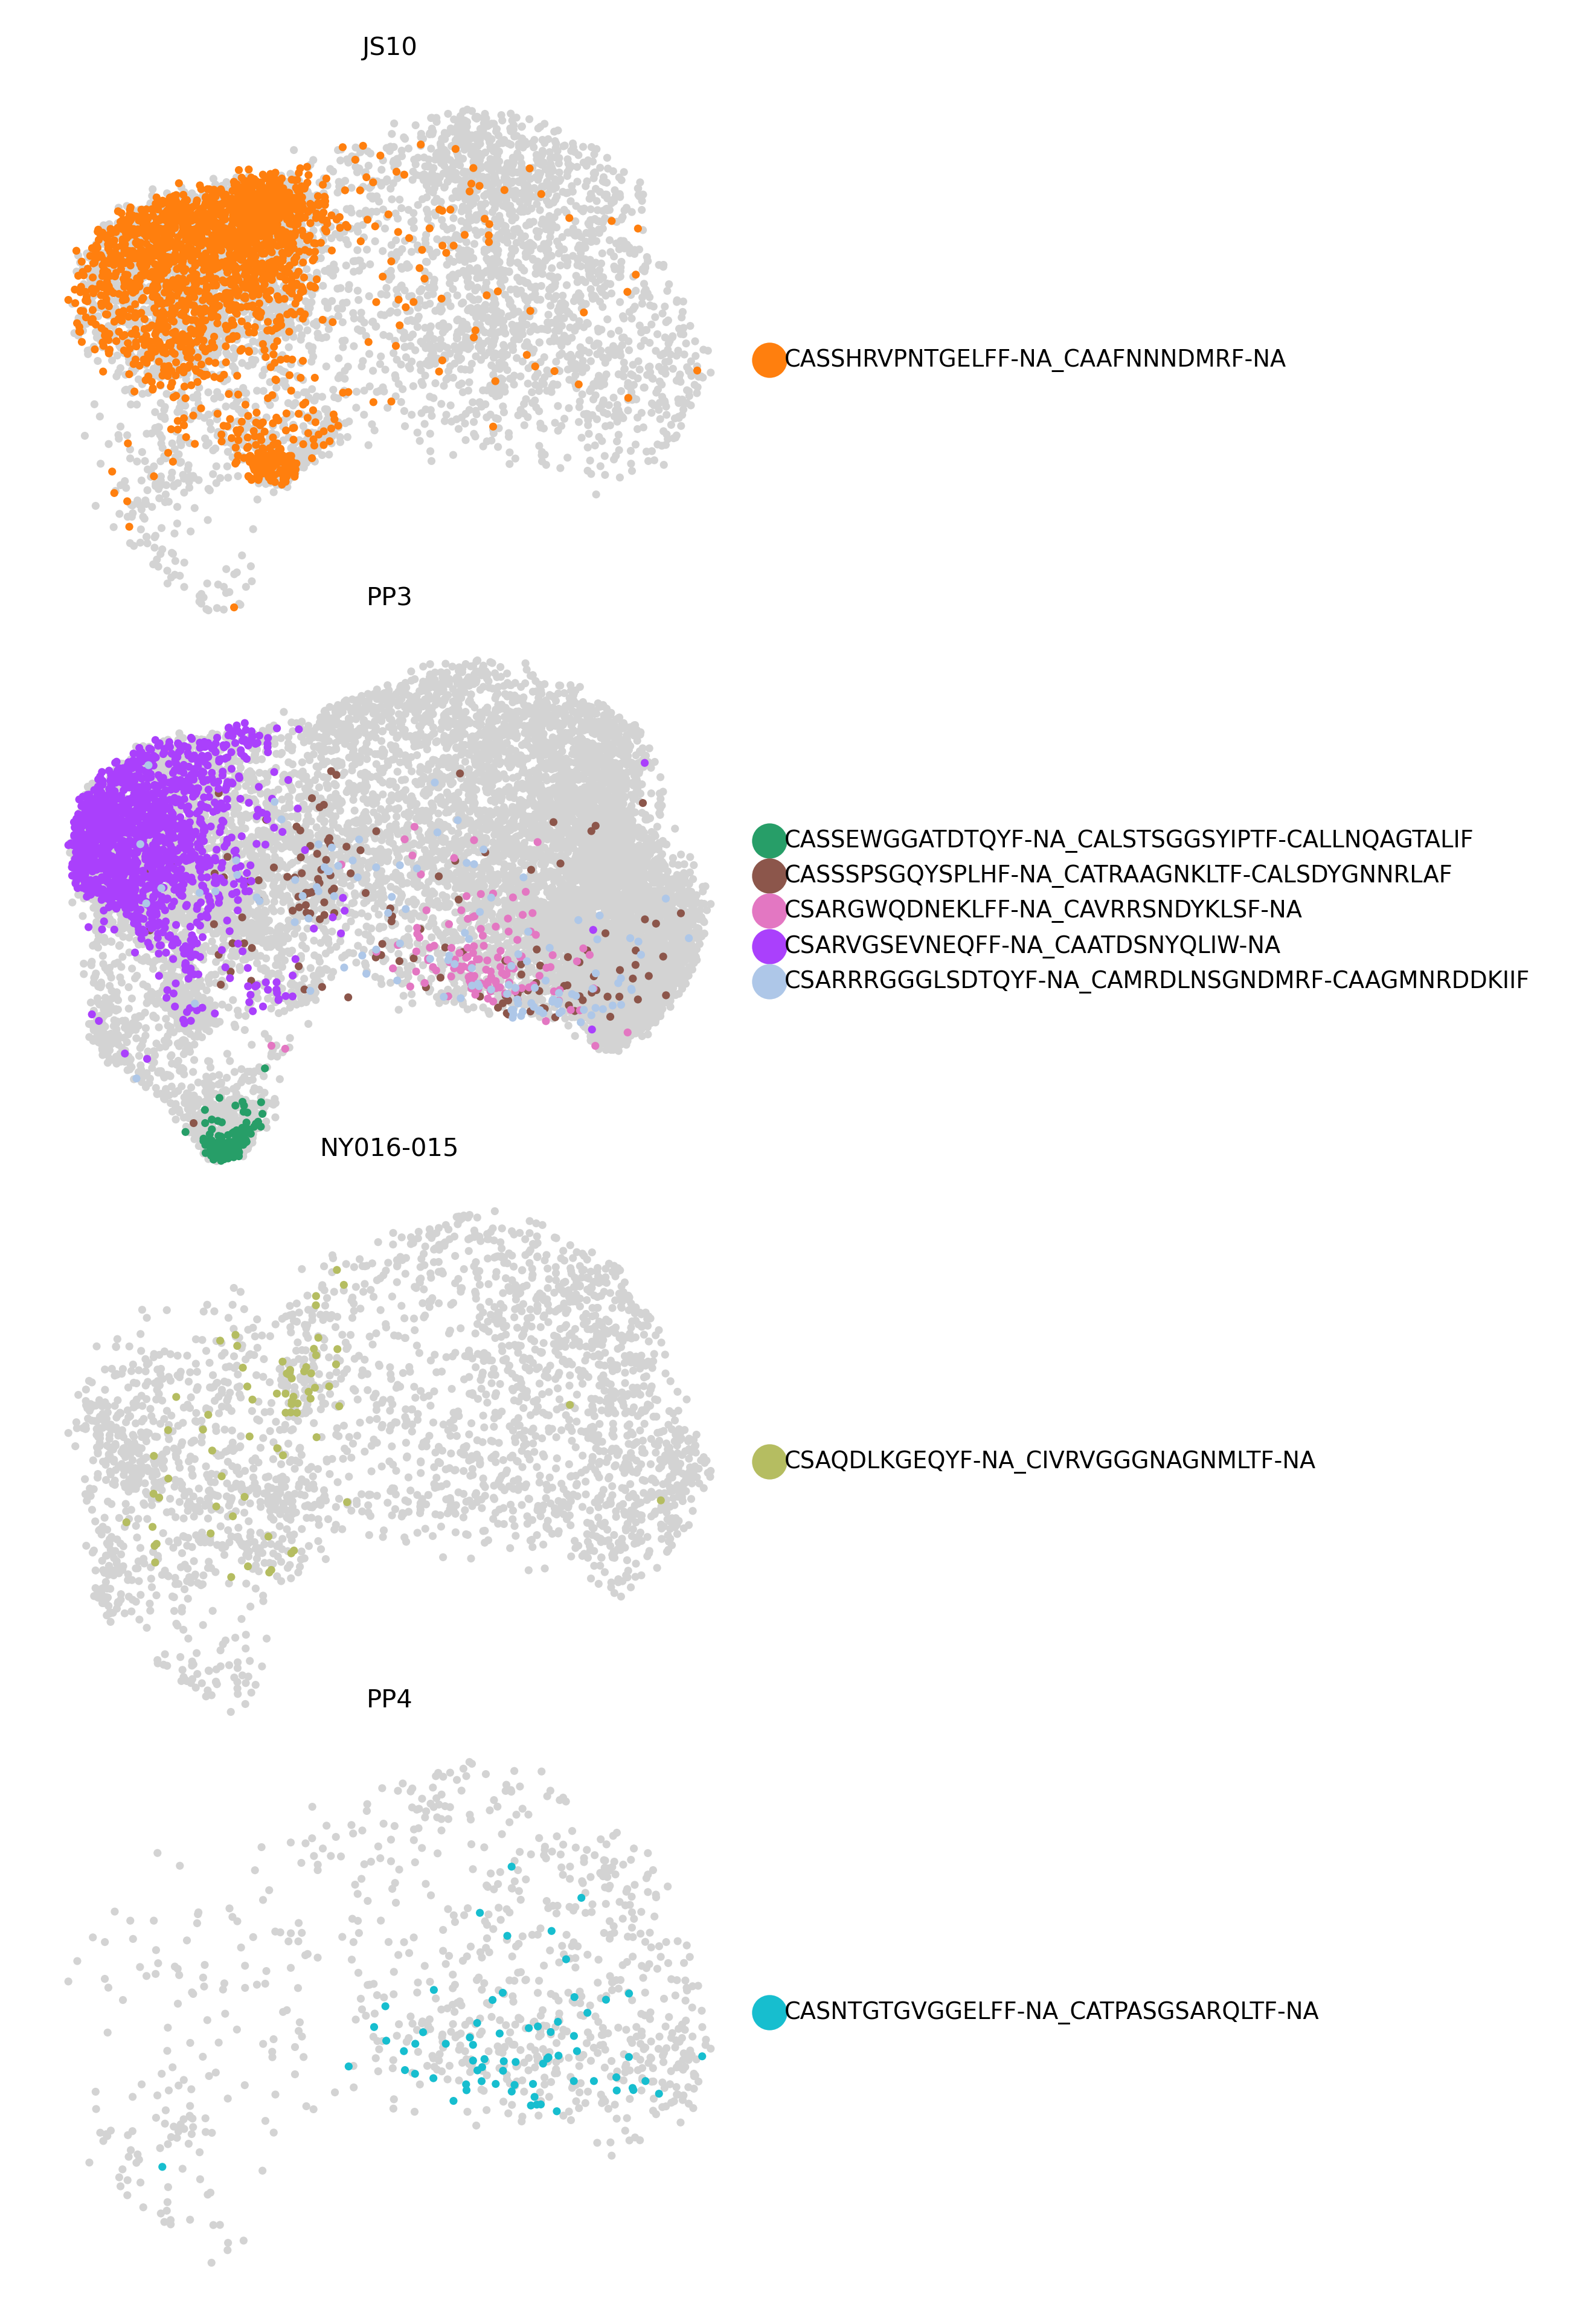

In [89]:
sc.settings.set_figure_params(dpi=300, dpi_save= 300, fontsize=5, facecolor='white', frameon=False, figsize=(0.8,0.8), transparent=True, format="pdf")
colorby = "top10_clonotypes"
fig, axs = plt.subplots(4,1, figsize = (2.5,8))
axs = axs.flatten()
for i, feature in enumerate(patients_of_interest):
    sc.pl.umap(adata[adata.obs["patient_id"] == feature], 
               color = colorby, wspace= 0.0, hspace = 0.0,
               size = 10, na_in_legend = False, title = feature, 
                  frameon=False, show=False, ax=axs[i])
plt.subplots_adjust(wspace=0, hspace=0)


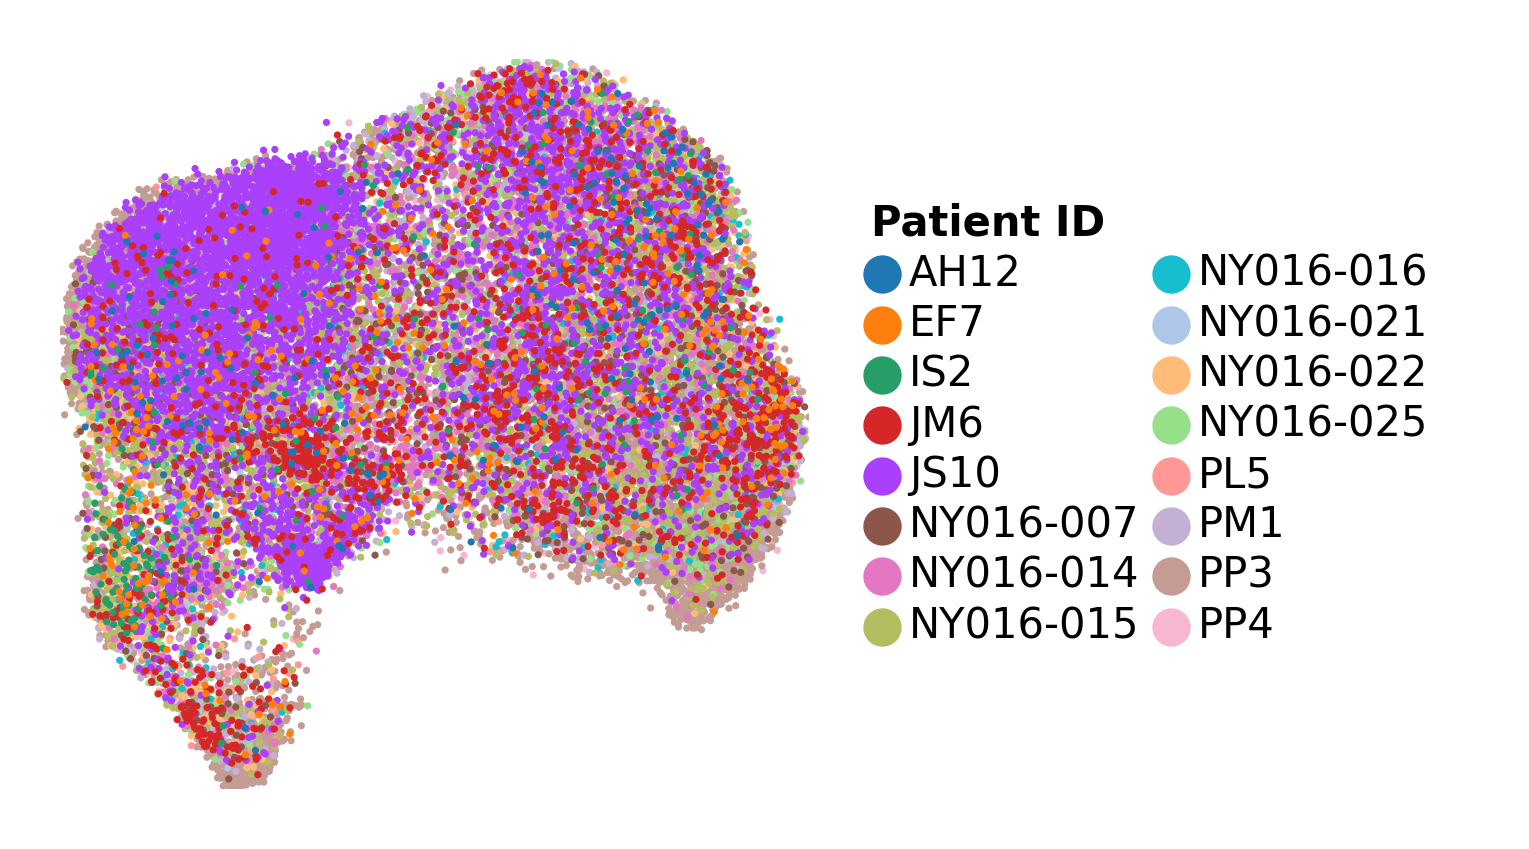

In [279]:
sc.settings.set_figure_params(dpi = 300, dpi_save= 300, fontsize=5, facecolor='white', frameon=True, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize = (1.6, 1.6))
plt.margins(x=0, y=0)
sc.pl.umap(adata, color = ['patient_id'], size=3, legend_fontsize=5,
           sort_order=True, frameon=False, 
           title="", na_in_legend = False, show=False, ax = ax, )
plt.legend(ncol=2, prop={'size': 5}, handletextpad=0.4, markerscale = 0.6, frameon = False, borderpad=1, columnspacing=0.5,
           labelspacing = 0.2, loc = 6, bbox_to_anchor = (1.0,0.5), title = "Patient ID", alignment = "left",
          title_fontproperties={'weight':'bold'})
# ax.set_ylabel("UMAP2", labelpad = 0.5)
# ax.set_xlabel("UMAP1", labelpad = 0.5)
# plt.savefig("human_figures/SCs_DTC_celltypes.pdf")
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(3.0, 3.0), vector_friendly = False)

In [24]:
adata.obs["Tissue"] = adata.obs["tissue"].map({"normal":"Normal", "tumor":"Tumor"})
sc.tl.embedding_density(adata, groupby="Tissue", key_added="tissue_ed")

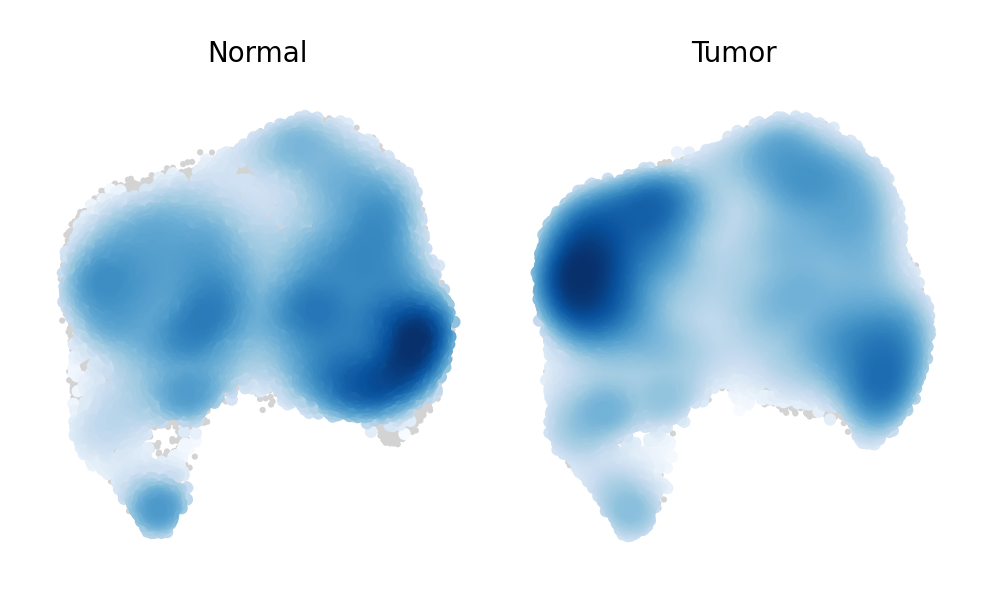

In [216]:
sc.settings.set_figure_params(dpi=200, dpi_save= 300, fontsize=5, facecolor='white',
                              frameon=False, figsize=(1.5,1.5), transparent=True, format="pdf")

fig = sc.pl.embedding_density(adata, key="tissue_ed", bg_dotsize=5.0, fg_dotsize=20.0,
                              return_fig=True, show=False, wspace=0.0, color_map = "Blues")
for i in range(1, 2+1):
    colorBar = fig.axes[-i]
    mappable = colorBar.collections[1]
    colorBar.remove()
    # plt.colorbar(mappable=mappable, ax=axs[-i], 
    #              fraction=0.20, aspect=5,
    #              pad=0 ,shrink = 0.2, location = "right")
# plt.subplots_adjust(wspace=-10, hspace=0)

In [6]:
adata.obs["Response"] = adata.obs["response"]

In [7]:
adata.obs["Response"].value_counts(dropna=False)

Response
R     19010
NR    17899
Name: count, dtype: int64

/home/groups/quake/mmantri/miniconda3/envs/python3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/groups/quake/mmantri/miniconda3/envs/python3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


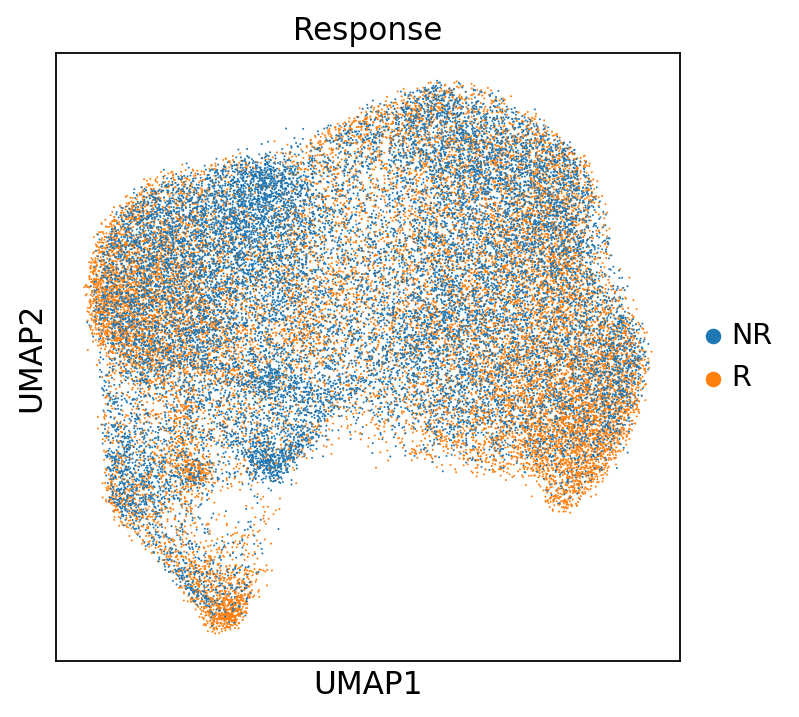

In [8]:
sc.pl.umap(adata, color = "Response")

In [19]:
adata.obs["Response"] = adata.obs["response"].map({"NR":"Non-responsive", "R":"Responsive"})

In [11]:
tumor = adata[adata.obs["tissue"] == "tumor"]
sc.tl.embedding_density(tumor, groupby="Response", key_added="response_ed")

/home/groups/quake/mmantri/miniconda3/envs/python3.9/lib/python3.9/site-packages/scanpy/tools/_embedding_density.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[density_covariate] = density_values


In [ ]:
# Figure 1B 

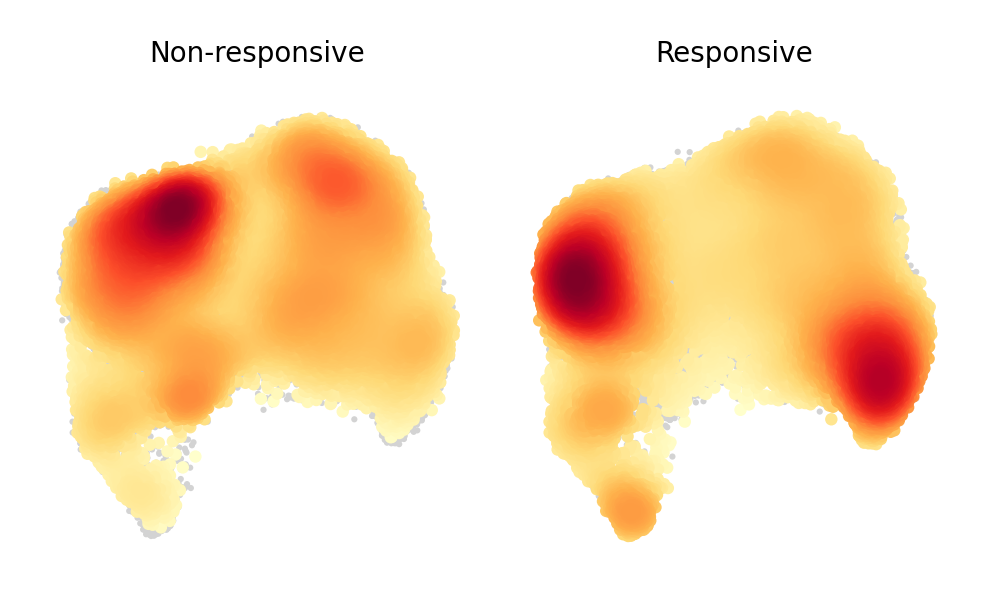

In [12]:
sc.settings.set_figure_params(dpi=200, dpi_save= 300, fontsize=5, facecolor='white',
                              frameon=False, figsize=(1.5,1.5), transparent=True, format="pdf")

fig = sc.pl.embedding_density(tumor, key="response_ed", bg_dotsize=5.0, fg_dotsize=20.0,
                              return_fig=True, show=False, wspace=0.0)
for i in range(1, 2+1):
    colorBar = fig.axes[-i]
    mappable = colorBar.collections[1]
    colorBar.remove()
    # plt.colorbar(mappable=mappable, ax=axs[-i], 
    #              fraction=0.20, aspect=5,
    #              pad=0 ,shrink = 0.2, location = "right")
plt.subplots_adjust(wspace=0, hspace=0)

In [157]:
pd.crosstab(adata.obs["tissue"], adata.obs["patient_id"])

patient_id  AH12  EF7   IS2   JM6  JS10  NY016-007  NY016-014  NY016-015  \
tissue                                                                     
LN             0    0  1066   214     0          0          0          0   
mettumor       0    0     0  1729     0          0          0          0   
normal         0  228     0  1091  1262        202          0        359   
tumor        230  167   206   630  5142        966       1597       2220   

patient_id  NY016-016  NY016-021  NY016-022  NY016-025  PL5   PM1   PP3  PP4  
tissue                                                                        
LN                  0          0          0          0    0     0  1842    0  
mettumor            0          0          0          0    0     0     0    0  
normal            490          0        147        508  121   652  2866  354  
tumor               0         81       1200       1367   87  1271  8064  550

In [16]:
adata.obs["new.clusters.names"] = adata.obs["new.clusters"].map(
    {"0" : "Cytotoxic MAIT 1",
                     "1" :  "Naïve MAIT 1", 
                     "2" : "MAIT 17", 
                     "3" :  "Activated MAIT 1", 
                     "4" :  "TRM", 
                     "5" : "Activated tissue resident"})

In [ ]:
# New Figure 1A

/home/groups/quake/mmantri/miniconda3/envs/python3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/groups/quake/mmantri/miniconda3/envs/python3.9/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


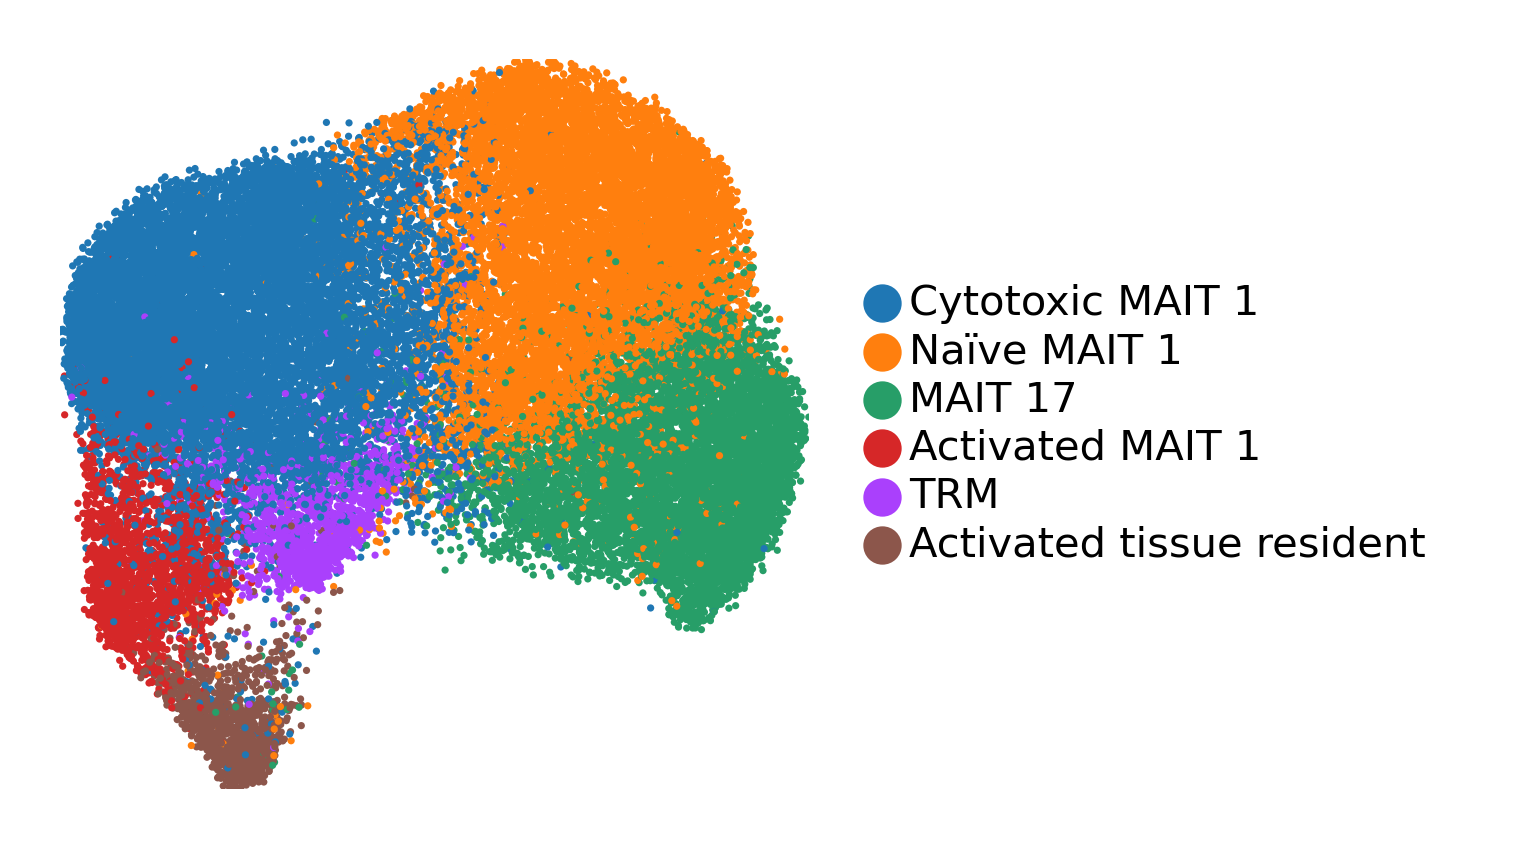

In [22]:
sc.settings.set_figure_params(dpi = 300, dpi_save= 300, fontsize=5, facecolor='white', frameon=True, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize = (1.6, 1.6))
plt.margins(x=0, y=0)
sc.pl.umap(adata, color = ['new.clusters.names'], size=3, legend_fontsize=5,
           sort_order=True, frameon=False, 
           title="", na_in_legend = False, show=False, ax = ax, )
plt.legend(ncol=1, prop={'size': 5}, handletextpad=0.4, markerscale = 0.6, 
           frameon = False, borderpad=1, columnspacing=0.5,
           labelspacing = 0.2, loc = 6, bbox_to_anchor = (1.0,0.5), title = "", alignment = "left",
          title_fontproperties={'weight':'bold'})
# ax.set_ylabel("UMAP2", labelpad = 0.5)
# ax.set_xlabel("UMAP1", labelpad = 0.5)
# plt.savefig("human_figures/SCs_DTC_celltypes.pdf")
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(3.0, 3.0), vector_friendly = False)
